<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Sprint Challenge
## *Data Science Unit 4 Sprint 1*

After a week of Natural Language Processing, you've learned some cool new stuff: how to process text, how turn text into vectors, and how to model topics from documents. Apply your newly acquired skills to one of the most famous NLP datasets out there: [Yelp](https://www.yelp.com/dataset/challenge). As part of the job selection process, some of my friends have been asked to create analysis of this dataset, so I want to empower you to have a head start.  

The real dataset is massive (almost 8 gigs uncompressed). I've sampled the data for you to something more managable for the Sprint Challenge. You can analyze the full dataset as a stretch goal or after the sprint challenge. As you work on the challenge, I suggest adding notes about your findings and things you want to analyze in the future.

## Challenge Objectives
*Successfully complete these all these objectives to earn a 2. There are more details on each objective further down in the notebook.*
* <a href="#p1">Part 1</a>: Write a function to tokenize the yelp reviews
* <a href="#p2">Part 2</a>: Create a vector representation of those tokens
* <a href="#p3">Part 3</a>: Use your tokens in a classification model on yelp rating
* <a href="#p4">Part 4</a>: Estimate & Interpret a topic model of the Yelp reviews

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

yelp = pd.read_json('./data/review_sample.json', lines=True)

In [2]:
yelp.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,nDuEqIyRc8YKS1q1fX0CZg,1,2015-03-31 16:50:30,0,eZs2tpEJtXPwawvHnHZIgQ,1,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...",10,n1LM36qNg4rqGXIcvVXv8w
1,eMYeEapscbKNqUDCx705hg,0,2015-12-16 05:31:03,0,DoQDWJsNbU0KL1O29l_Xug,4,Came here for lunch Togo. Service was quick. S...,0,5CgjjDAic2-FAvCtiHpytA
2,6Q7-wkCPc1KF75jZLOTcMw,1,2010-06-20 19:14:48,1,DDOdGU7zh56yQHmUnL1idQ,3,I've been to Vegas dozens of times and had nev...,2,BdV-cf3LScmb8kZ7iiBcMA
3,k3zrItO4l9hwfLRwHBDc9w,3,2010-07-13 00:33:45,4,LfTMUWnfGFMOfOIyJcwLVA,1,We went here on a night where they closed off ...,5,cZZnBqh4gAEy4CdNvJailQ
4,6hpfRwGlOzbNv7k5eP9rsQ,1,2018-06-30 02:30:01,0,zJSUdI7bJ8PNJAg4lnl_Gg,4,"3.5 to 4 stars\n\nNot bad for the price, $12.9...",5,n9QO4ClYAS7h9fpQwa5bhA


## Part 1: Tokenize Function
<a id="#p1"></a>

Complete the function `tokenize`. Your function should
- accept one document at a time
- return a list of tokens

You are free to use any method you have learned this week.

In [2]:
def tokenize(doc):
    
    return [token for token in simple_preprocess(doc) if token not in STOPWORDS]

## Part 2: Vector Representation
<a id="#p2"></a>
1. Create a vector representation of the reviews
2. Write a fake review and query for the 10 most similiar reviews, print the text of the reviews. Do you notice any patterns?
    - Given the size of the dataset, it will probably be best to use a `NearestNeighbors` model for this. 

In [12]:
from sklearn.neighbors import NearestNeighbors

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
import spacy
nlp = spacy.load("en_core_web_lg")

In [15]:
vect = TfidfVectorizer(stop_words='english', tokenizer=tokenize)
sgdc = SGDClassifier()

def get_word_vectors(doc):
    return [nlp(doc).vector]

yelp['vectors'] = yelp['text'].apply(get_word_vectors)

In [19]:
def distance(instance1, instance2):
    # just in case, if the instances are lists or tuples:
    instance1 = np.array(instance1) 
    instance2 = np.array(instance2)
    
    return np.linalg.norm(instance1 - instance2)

In [20]:
distance(vectors[0], vectors[1])

1.3356242

In [21]:
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(list(yelp['vectors']))

In [24]:
fake_review = "The food was pretty mediocre, I don't think I'll be returning."

fake_vector = get_word_vectors(fake_review)

dist, ind = nbrs.kneighbors(fake_vector.reshape(1, -1), 10)

In [33]:
for indice in ind[0]:
    print(yelp.iloc[indice]['text'])


I absolutely love Hash Kitchen! I've been to a different location and really loved it and am so happy that they opened one in Chandler!

It was awhile since I've been there but I ordered pancakes, I want to say it was Boston creme or something custard. ( I can't find it on their website) It was really good and a very large portion. 

We came on a Saturday morning so it was really busy. The wait was about 30 minutes or so. I'm not sure if they do reservations, but if they do, you should definitely make one. I really wish that I could drink, because their drink menu looks amazing!They also have a dj there on Saturdays, which is good and bad. Good because they played really good music, bad because it was really loud, so I couldn't hear my friend that well.
I love Dairy Queen very much which is why I don't want to say anything bad but I go here fairly often and each time I come something almost gets missed. I really love the ice cream so I would be devastated if I didn't get it because the

#### Not sure there's a strong correlation between the reviews. I suspect it's because I didn't write a very long review so it didn't have a large enough group of vectors to be similar enough to other reviews.

## Part 3: Classification
<a id="#p3"></a>
Your goal in this section will be to predict `stars` from the review dataset. 

1. Create a piepline object with a sklearn `CountVectorizer` or `TfidfVector` and any sklearn classifier. Use that pipeline to estimate a model to predict `stars`. Use the Pipeline to predict a star rating for your fake review from Part 2. 
2. Tune the entire pipeline with a GridSearch

In [36]:
pipe = Pipeline([('vect', vect), ('clf', sgdc)])
X = yelp['text']
y = yelp['stars']
pipe.fit(X, y)

/usr/local/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...m_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))])

In [39]:
pipe.predict([fake_review])[0]

2

Seems about right, I'll try again with a longer fake review if I have time.

## Part 4: Topic Modeling

Let's find out what those yelp reviews are saying! :D

1. Estimate a LDA topic model of the review text
2. Create 1-2 visualizations of the results
    - You can use the most important 3 words of a topic in relevant visualizations. Refer to yesterday's notebook to extract. 
3. In markdown, write 1-2 paragraphs of analysis on the results of your topic model

__*Note*__: You can pass the DataFrame column of text reviews to gensim. You do not have to use a generator.

In [41]:
def pd_stream(df):
    for index, row in df.iterrows():
        text = row['text']
        tokens = tokenize(text)
        yield tokens

In [42]:
id2word = corpora.Dictionary(pd_stream(yelp))

In [43]:
corpus = [id2word.doc2bow(text) for text in pd_stream(yelp)]

In [44]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=10,
                                            random_state=42,
                                            update_every=1,
                                            chunksize=200,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

In [46]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.024*"time" + 0.016*"got" + 0.013*"service" + 0.012*"went" + 0.012*"like" + 0.011*"know" + 0.011*"said" + 0.010*"people" + 0.009*"day" + 0.009*"told"'), (1, '0.022*"staff" + 0.021*"great" + 0.016*"recommend" + 0.015*"friendly" + 0.014*"new" + 0.012*"work" + 0.012*"service" + 0.011*"amazing" + 0.011*"ve" + 0.010*"best"'), (2, '0.015*"dog" + 0.013*"completely" + 0.012*"recommended" + 0.012*"showed" + 0.011*"butter" + 0.011*"crispy" + 0.008*"delivery" + 0.008*"dogs" + 0.008*"original" + 0.007*"mins"'), (3, '0.033*"car" + 0.016*"company" + 0.012*"house" + 0.009*"phoenix" + 0.008*"certainly" + 0.007*"road" + 0.006*"lemon" + 0.006*"guacamole" + 0.006*"moving" + 0.006*"poor"'), (4, '0.041*"food" + 0.035*"good" + 0.014*"ordered" + 0.012*"chicken" + 0.012*"service" + 0.011*"restaurant" + 0.011*"try" + 0.011*"place" + 0.011*"delicious" + 0.010*"menu"'), (5, '0.062*"place" + 0.043*"great" + 0.041*"love" + 0.013*"burger" + 0.012*"beer" + 0.011*"awesome" + 0.011*"favorite" + 0.011*"selection

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, df, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    tokens = list(pd_stream(df))
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            stream = pd_stream(df)
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

# Can take a long time to run.
coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        df=yelp, 
                                                        start=2, 
                                                        limit=40, 
                                                        step=6,
                                                        passes=3)

topic_coherence = pd.DataFrame.from_records(coherence_values)

import seaborn as sns

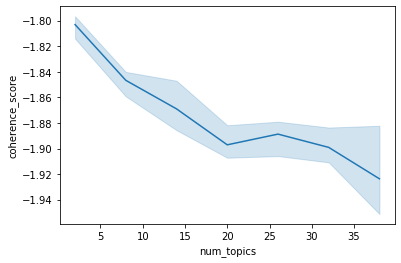

In [52]:
sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

# This seems bad. I think the simple_preprocess tokenizer isn't very good? I'm sure I could improve my using spacy or even just tfidvectorizer maybe.

In [47]:
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

/usr/local/anaconda3/envs/nlp/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.252280 -0.071409       1        1  23.720123
0     -0.234316  0.127955       2        1  23.003229
1     -0.151692  0.186402       3        1  13.257697
6     -0.158423 -0.109435       4        1  12.860229
5     -0.061471 -0.170812       5        1   7.842518
7      0.141069 -0.220393       6        1   4.819226
8      0.162357  0.142023       7        1   4.366069
2      0.188736  0.015038       8        1   3.647086
3      0.172480  0.089112       9        1   3.625141
9      0.193541  0.011518      10        1   2.858682, topic_info=     Category         Freq          Term        Total  loglift  logprob
144   Default  4698.000000          food  4698.000000  30.0000  30.0000
133   Default  4490.000000         place  4490.000000  29.0000  29.0000
208   Default  4057.000000         great  4057.000000  28.0000  28.0000
40    Default  4380.000000          good  4380.000000  27.0000  27.0000
735   Default  1558.000000          love  1558.000000  26.0000  26.0000
34    Default  3464.000000          time  3464.000000  25.0000  25.0000
46    Default  1483.000000         staff  1483.000000  24.0000  24.0000
394   Default   729.000000         pizza   729.000000  23.0000  23.0000
1266  Default  1543.000000       ordered  1543.000000  22.0000  22.0000
75    Default  2089.000000           got  2089.000000  21.0000  21.0000
349   Default   852.000000        cheese   852.000000  20.0000  20.0000
184   Default  1096.000000     recommend  1096.000000  19.0000  19.0000
1277  Default  1384.000000       chicken  1384.000000  18.0000  18.0000
103   Default   980.000000          room   980.000000  17.0000  17.0000
116   Default   956.000000         vegas   956.000000  16.0000  16.0000
2183  Default   578.000000           car   578.000000  15.0000  15.0000
39    Default  1356.000000      friendly  1356.000000  14.0000  14.0000
45    Default  3468.000000       service  3468.000000  13.0000  13.0000
771   Default   609.000000         cream   609.000000  12.0000  12.0000
478   Default  1252.000000          know  1252.000000  11.0000  11.0000
651   Default  1272.000000    restaurant  1272.000000  10.0000  10.0000
30    Default  1212.000000          said  1212.000000   9.0000   9.0000
359   Default  1203.000000     delicious  1203.000000   8.0000   8.0000
122   Default  1832.000000          best  1832.000000   7.0000   7.0000
180   Default  1174.000000          menu  1174.000000   6.0000   6.0000
117   Default  1502.000000          went  1502.000000   5.0000   5.0000
1066  Default  1071.000000           new  1071.000000   4.0000   4.0000
192   Default  1384.000000       amazing  1384.000000   3.0000   3.0000
131   Default  1511.000000        people  1511.000000   2.0000   2.0000
18    Default  3382.000000          like  3382.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
2971  Topic10   169.777100     literally   170.633987   3.5498  -4.3933
2970  Topic10   165.948578       exactly   166.805389   3.5497  -4.4161
919   Topic10   151.573425        pieces   152.430283   3.5492  -4.5067
922   Topic10   135.946014         solid   136.802933   3.5485  -4.6155
204   Topic10   133.041260      fabulous   133.898239   3.5484  -4.6371
911   Topic10   102.151222        indian   103.007935   3.5465  -4.9013
2969  Topic10    99.062584           bag    99.919472   3.5462  -4.9320
206   Topic10    92.805946         funny    93.662781   3.5456  -4.9973
3107  Topic10    81.831436    additional    82.688293   3.5444  -5.1231
918   Topic10    81.600304         parts    82.457199   3.5444  -5.1260
1037  Topic10    68.754501         chair    69.611328   3.5424  -5.2973
554   Topic10    68.177254        flight    69.034035   3.5423  -5.3057
3479  Topic10    67.604729       buffets    68.461540   3.5422  -5.3141
4450  Topic10    67.487259   informative    68.344215   3.5422  -5.31

## Analysis

I could have definitely done more stopword cleanup as it seems some topics have words that might be somewhat unhelpful like "got." The topics definitely seem very distinct but I think I could have chosen less than 10, at the very least 9 as topics 8 and 10 are almost completely overlapping and have very similar keywords. Some things that I found interesting is topics like topic 1 which seems to be well liked restaurants, topic 4 seems to be hotels and restaurants in Las Vegas or topic 2 which seems to be people who waited a long time for something.

In [ ]:
# Try again with fewer topics

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=5,
                                            random_state=42,
                                            update_every=1,
                                            chunksize=200,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=False)

In [54]:
pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

/usr/local/anaconda3/envs/nlp/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.182720 -0.046415       1        1  35.778946
2      0.068048 -0.137525       2        1  22.980371
4      0.150452  0.280114       3        1  20.278162
1     -0.076313 -0.223464       4        1  16.659849
3     -0.324908  0.127290       5        1   4.302671, topic_info=     Category         Freq         Term        Total  loglift  logprob
208   Default  4186.000000        great  4186.000000  30.0000  30.0000
133   Default  4577.000000        place  4577.000000  29.0000  29.0000
144   Default  4691.000000         food  4691.000000  28.0000  28.0000
103   Default   903.000000         room   903.000000  27.0000  27.0000
40    Default  4366.000000         good  4366.000000  26.0000  26.0000
75    Default  2074.000000          got  2074.000000  25.0000  25.0000
1277  Default  1362.000000      chicken  1362.000000  24.0000  24.0000
1266  Default  1529.000000      ordered  1529.000000  23.0000  23.0000
735   Default  1624.000000         love  1624.000000  22.0000  22.0000
122   Default  1873.000000         best  1873.000000  21.0000  21.0000
30    Default  1198.000000         said  1198.000000  20.0000  20.0000
192   Default  1416.000000      amazing  1416.000000  19.0000  19.0000
39    Default  1399.000000     friendly  1399.000000  18.0000  18.0000
25    Default   957.000000      minutes   957.000000  17.0000  17.0000
359   Default  1188.000000    delicious  1188.000000  16.0000  16.0000
92    Default  1702.000000         nice  1702.000000  15.0000  15.0000
349   Default   864.000000       cheese   864.000000  14.0000  14.0000
371   Default   939.000000        fresh   939.000000  13.0000  13.0000
37    Default  1426.000000         came  1426.000000  12.0000  12.0000
1940  Default   406.000000        hotel   406.000000  11.0000  11.0000
34    Default  3424.000000         time  3424.000000  10.0000  10.0000
387   Default  1428.000000        order  1428.000000   9.0000   9.0000
812   Default   674.000000        store   674.000000   8.0000   8.0000
400   Default   749.000000        sauce   749.000000   7.0000   7.0000
421   Default   796.000000        asked   796.000000   6.0000   6.0000
545   Default   719.000000         meal   719.000000   5.0000   5.0000
45    Default  3469.000000      service  3469.000000   4.0000   4.0000
117   Default  1484.000000         went  1484.000000   3.0000   3.0000
535   Default   883.000000         work   883.000000   2.0000   2.0000
137   Default  1061.000000          bar  1061.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
3488   Topic5    65.598778          bus    66.386185   3.1340  -5.7531
1258   Topic5    66.079765      country    66.911163   3.1334  -5.7458
76     Topic5    62.172421       hotels    62.956371   3.1334  -5.8068
96     Topic5    62.883499     property    63.681091   3.1333  -5.7954
1891   Topic5    61.404667    furniture    62.205151   3.1330  -5.8192
2739   Topic5    61.333855      stylist    62.136497   3.1329  -5.8203
2451   Topic5    65.141212     answered    66.011841   3.1327  -5.7601
1930   Topic5    58.477016       carpet    59.264652   3.1326  -5.8680
2485   Topic5    64.773636   technician    65.657890   3.1324  -5.7658
4450   Topic5    60.066341  informative    60.887951   3.1323  -5.8412
3846   Topic5    57.253689        sleep    58.041977   3.1323  -5.8892
101    Topic5    53.572681       resort    54.366138   3.1312  -5.9556
3324   Topic5    53.957603        state    54.763519   3.1311  -5.9485
3990   Topic5    51.613537           le    52.391525   3.1310  -5.9929
3998   Topic5    46.714146         pour    47.496220   3.1293  -6.0926
2592   Topic5    46.568367         beds    47.350494   3.1293  -6.0957
2648   Topic5    47.330208          tub    48.132561   3.1291  -6.0795
3152   Topic5    46.997177       points    47.800514   3.1290  -6.0866
8939   Topic5    47.468914   

### These topics seem better

Good restaurants, bad restaurants, professional services, hotels and then another topic of restaurant reviews that use lots of adjectives to describe food and such, probably the kinds of reviews Darek used to get.

## Stretch Goals

Complete one of more of these to push your score towards a three: 
* Incorporate named entity recognition into your analysis
* Compare vectorization methods in the classification section
* Analyze more (or all) of the yelp dataset - this one is v. hard. 
* Use a generator object on the reviews file - this would help you with the analyzing the whole dataset.
* Incorporate any of the other yelp dataset entities in your analysis (business, users, etc.)

## Oops, using a generator was a stretch goal. Guess I did that already.

In [5]:
from wordcloud import WordCloud, STOPWORDS

fivestarreviews = yelp[yelp['stars'] == 5]
fivestarreviews['tokens'] = fivestarreviews['text'].apply(tokenize)

fivestarreviews = fivestarreviews.reset_index(drop=True)

fivestartokens = fivestarreviews['tokens'].values

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS
).generate(str(fivestartokens))

fig = plt.figure(
    figsize=(10,7),
    facecolor = 'k',
    edgecolor = 'k'
)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

ModuleNotFoundError: No module named 'wordcloud'